*********
*********
### 📌 **Project Introduction: Transaction Forecasting & Anomaly Detection** 
--------
----------

This project focuses on **analyzing credit card transactions** to uncover spending patterns and forecast future trends using **Facebook Prophet**. The goal is to help financial institutions and businesses enhance budgeting, marketing, and customer experience through predictive analytics.

#### **Key Objectives**  
1. **Analyze Spending Behavior** 🛒  
   - Identify top spending categories and transaction trends.  
   - Detect seasonal patterns and peak spending periods.  

2. **Forecast Future Transactions** 📈  
   - Use time-series forecasting (Facebook Prophet) to predict future spending.  
   - Incorporate external factors (holidays, economic indicators).  

3. **Anomaly Detection** 🚨  
   - Identify unusual spending behaviors and potential fraud.  
   - Differentiate normal variations from actual anomalies.  

4. **Deployment & Usability** 🚀  
   - Develop a **Streamlit web app** for interactive forecasting.  
   - Enable real-time transaction monitoring for businesses.  

---

In [1]:
!pip install --upgrade mlxtend -q
!pip install --upgrade category-encoders -q
!pip install scikit-learn==1.6.0 -q
!pip install prophet -q
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 90.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 101.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.2 MB/s eta 0:00:00:00:0100:01


In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from mlxtend.frequent_patterns import apriori, association_rules
import pickle
import os
from itertools import product
from prophet import Prophet

In [9]:
# Load dataset
df = pd.read_csv("/kaggle/input/credit-card-transactions-dataset/credit_card_transactions.csv")

# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## dropping column Unnamed as we dont need it and merch_zipcode fue to null values

In [10]:
if "Unnamed: 0" or "merch_zipcode" in df.columns:
    df.drop(["Unnamed: 0","merch_zipcode"], axis=1, inplace=True)


In [11]:
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [12]:
# Check for missing values
print(df.isnull().sum())



trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [13]:
# Describe numerical features
stats = df.describe()
stats

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


*****
******
## Feature Engineering
*****
****

### 🔹 Step 1: Convert trans_date_trans_time to Datetime

In [14]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])


### 🔹 Step 2: Convert dob to Age

In [15]:
df["dob"] = pd.to_datetime(df["dob"])
df["customer_age"] = df["dob"].apply(lambda x: datetime.now().year - x.year)


📌 Why? Age-based spending insights (e.g., younger vs. older customers).

### 🔹 Step 3: Total Spending Per Customer

In [16]:
df["total_spent"] = df.groupby("cc_num")["amt"].transform("sum")



📌 Why?

- Can be used for customer segmentation (e.g., VIP customers).
- Helps in budgeting recommendations.

### 🔹 Step 4. Transaction Frequency Per Customer
Tracks how often a customer makes purchases.

In [17]:
df["transaction_count"] = df.groupby("cc_num")["amt"].transform("count")


📌 Why?

Can help detect fraudulent activity (unusual spending spikes).
Useful for personalized financial recommendations.

In [18]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,customer_age,total_spent,transaction_count
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,37,177233.44,2028
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,47,163466.44,3030
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,63,33132.63,503
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,58,35878.90,493
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,39,191974.21,2017


******
******
## Exploratory Data Analysis
*****
*****

## 1 Basic EDA Questions (Beginner-Level)
1. What are the top spending categories by transaction volume and amount?
2. How does spending vary over time (daily, weekly, monthly trends)?
3. What are the peak spending hours in a day?
4. What is the most common payment method used?
5. Which merchants have the highest transactions?

### 🔹 1. Top Spending Categories by Transaction Volume & Amount
We’ll calculate both:

- Transaction Volume (Total number of transactions per category)
- Total Amount Spent (Sum of all transaction amounts per category)

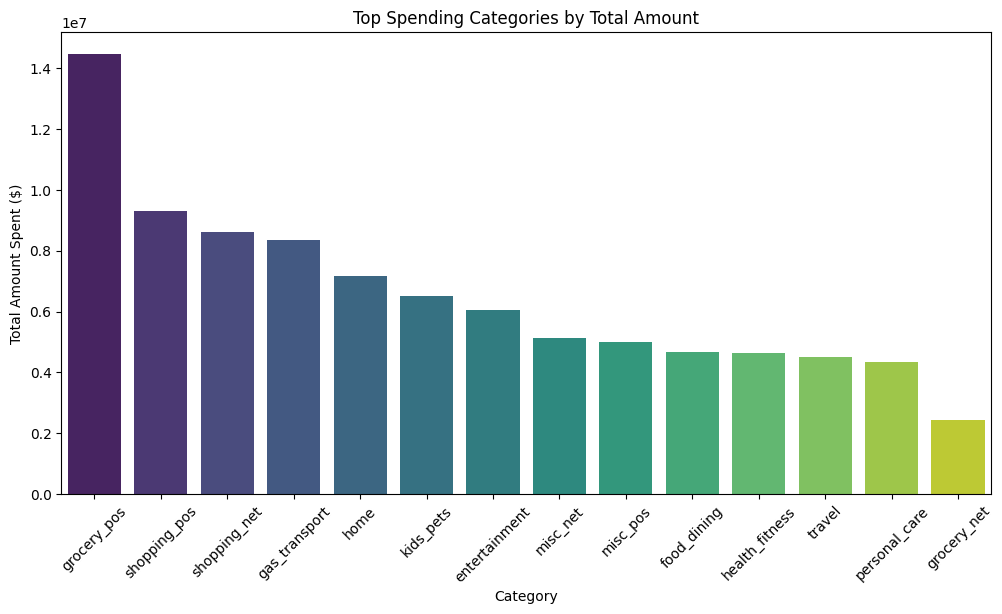

In [19]:
# Group by category and aggregate
category_stats = df.groupby("category").agg(
    transaction_volume=("amt", "count"),  # Number of transactions
    total_amount_spent=("amt", "sum")     # Total amount spent
).sort_values(by="total_amount_spent", ascending=False)

category_stats.head()

# Plot top spending categories by amount
plt.figure(figsize=(12, 6))
sns.barplot(x=category_stats.index, y=category_stats["total_amount_spent"], palette="viridis")
plt.xticks(rotation=45)
plt.title("Top Spending Categories by Total Amount")
plt.xlabel("Category")
plt.ylabel("Total Amount Spent ($)")
# Save the plot with the title as the filename
plt.savefig("top_spending_categories.png")
plt.show()




## 📌 Insights: Top Spending Categories by Transaction Volume & Amount
### 1. Highest Transaction Volume  
- **Gas & Transport** has the highest number of transactions (**131,659**), indicating frequent spending, possibly on fuel or transportation services.  

### 2. Highest Total Spending  
- **Grocery (POS)** leads in total spending (**~$14.46M**), making it a major expense category.  

### 3. Shopping Trends  
- **Shopping (POS)** has more transactions (**116,672**) than **Shopping (Net)** (**97,543**), but a lower total spend.  
- This suggests that online purchases might have higher average transaction values.  

### 4. Home-related Expenses  
- **Home spending** is significant (**$7.17M**) but has fewer transactions compared to other categories.  
- This indicates higher-value but less frequent purchases.  

### 🔹 2. How Spending Varies Over Time (Daily, Weekly, Monthly Trends)
Let's analyze the spending pattern using time-based aggregations.

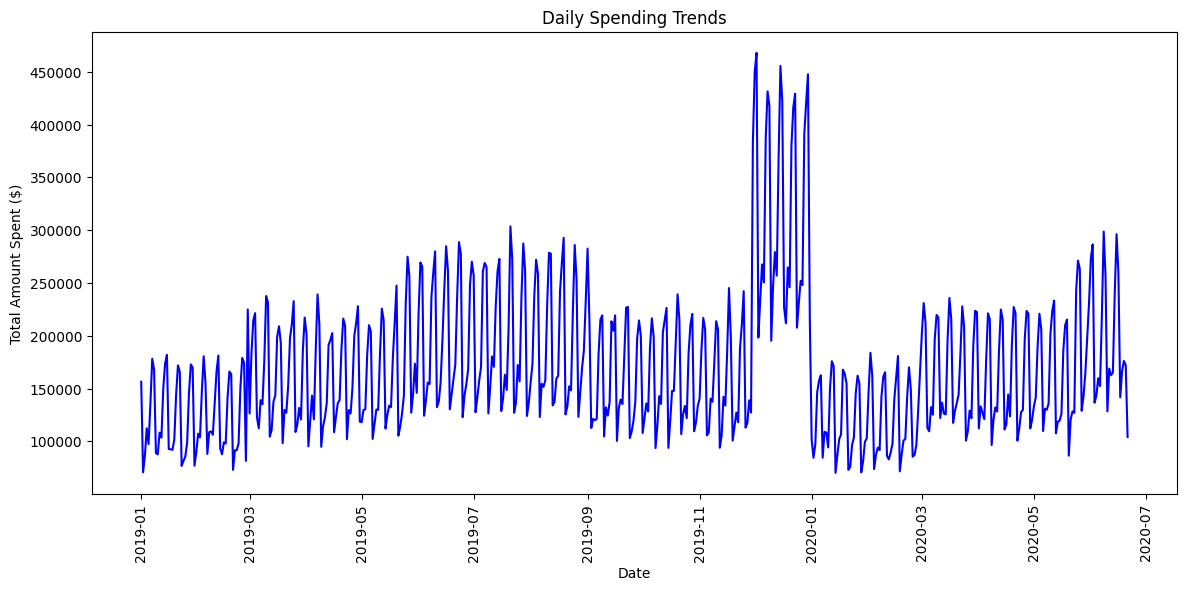

In [20]:
# Aggregate total spending per day
df["transaction_date"] = df["trans_date_trans_time"].dt.date
daily_spending = df.groupby("transaction_date")["amt"].sum()

# Plot daily spending trend
plt.figure(figsize=(14, 6))
sns.lineplot(x=daily_spending.index, y=daily_spending.values, color="blue")
plt.title("Daily Spending Trends")
plt.xlabel("Date")
plt.ylabel("Total Amount Spent ($)")
plt.xticks(rotation=90)
# Save the plot with the title as the filename
plt.savefig("Daily Spending Trends.png")
plt.show()


## 📌 Insights 📊 Spending Trends Analysis  

### 1. Daily Trends Observations  
- Spending follows a clear **cyclical pattern**, indicating periodic peaks and dips.  
- There is a noticeable **spike around late 2019 to early 2020**, possibly due to seasonal events like holidays or major purchases.  
- Post-peak, spending decreases but retains some periodic fluctuations.  

### 2. Weekly Trends Observations  
- The **oscillations suggest weekly spending cycles**, likely influenced by payday patterns, weekends, or planned purchases.  
- There are **higher spending intervals**, which could indicate recurring expenses or salary-based spending behavior.  

### 3. Seasonal Trends  
- A **significant spike** at the start of 2020 suggests a holiday or year-end effect.  
- The overall trend shows **growth in spending over time**, with fluctuations becoming more pronounced.  


### 🔹 3. What Are the Peak Spending Hours in a Day?
Extract the transaction hour and visualize the trend.

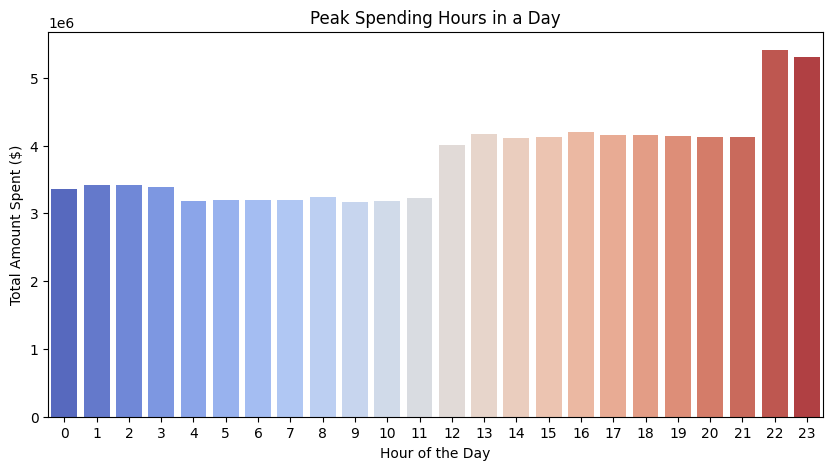

In [21]:
# Extract hour of transaction
df["transaction_hour"] = df["trans_date_trans_time"].dt.hour

# Aggregate spending by hour
hourly_spending = df.groupby("transaction_hour")["amt"].sum()

# Plot spending per hour
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_spending.index, y=hourly_spending.values, palette="coolwarm")
plt.title("Peak Spending Hours in a Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Amount Spent ($)")
plt.xticks(range(0, 24))

# Save the plot with the title as the filename
plt.savefig("Peak Spending Hours in a Day.png")
plt.show()


## 📌 Insights: 🔥 Peak Spending Summary  

- **Peak spending occurs between 10 PM - 11 PM**, likely due to online shopping or bill payments.  
- **Spending gradually increases from 12 PM onwards**, indicating more retail and entertainment transactions.  
- **Lowest spending happens between 4 AM - 8 AM**, aligning with sleeping hours.  
- **Evening hours drive the most transactions**, making it the prime spending period.  


### 🔹 4. What Is the Most Common Payment Method Used?
### Observation on Payment Methods
Since this dataset consists entirely of credit card transactions, all payments are made via credit cards. Therefore, analyzing payment methods is redundant.



### 🔹 5. Which Merchants Have the Highest Transactions?
We will check which merchants process the most transactions.

In [22]:
df["merchant"].value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

In [23]:
df["merchant"] = df["merchant"].str.replace("fraud_", "", regex=False)
# Count transactions per merchant
merchant_transactions = df["merchant"].value_counts().head(10)
merchant_transactions


merchant
Kilback LLC                   4403
Cormier LLC                   3649
Schumm PLC                    3634
Kuhn LLC                      3510
Boyer PLC                     3493
Dickinson Ltd                 3434
Cummerata-Jones               2736
Kutch LLC                     2734
Olson, Becker and Koch        2723
Stroman, Hudson and Erdman    2721
Name: count, dtype: int64

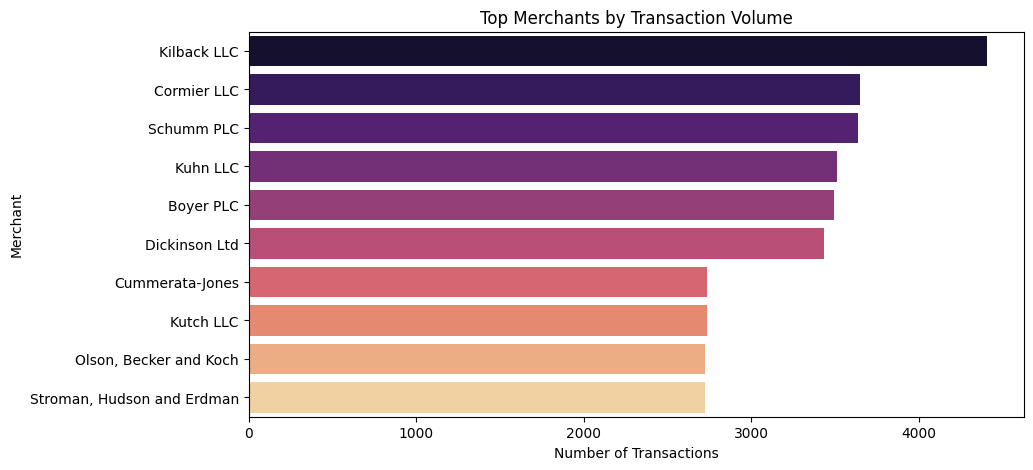

In [24]:
# Create the plot
plt.figure(figsize=(10, 5))
sns.barplot(y=merchant_transactions.index, x=merchant_transactions.values, palette="magma")
plt.title("Top Merchants by Transaction Volume")
plt.xlabel("Number of Transactions")
plt.ylabel("Merchant")

# Save the figure
plt.savefig("top_merchants.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## 📌 Insights: 🏪 Top Merchants by Transaction Volume  

- **Kilback LLC** has the highest number of transactions (**4,403**), making it the most frequently used merchant.  
- **Cormier LLC, Schumm PLC, and Kuhn LLC** follow closely, each with over **3,500** transactions.  
- **The top 10 merchants all have over 2,700 transactions**, indicating high customer engagement.  
- The distribution suggests **a mix of retail, services, and essential spending** across multiple vendors.  


*****
****

## 4.2 Intermediate EDA Questions
1. Are there seasonal trends in spending across different categories?
2. How do different customer segments (high spenders vs. low spenders) behave?
3. What is the distribution of transaction amounts (e.g., histogram, boxplot analysis)?
4. Are there any correlations between spending behavior and location?
5. How does spending behavior change before and after payday?

### ♦️ Part 1. Customer Segments: High Spenders vs. Low Spenders

In [25]:
# Step 1: Define Spending Segments
# Categorizing customers into Low, Medium, and High Spenders using percentiles

df['spending_segment'] = pd.qcut(df['total_spent'], q=[0, 0.33, 0.66, 1], labels=['Low Spender', 'Medium Spender', 'High Spender'])

In [26]:
# Step 2: Compare Spending Behavior
# Analyzing spending differences across segments: average transaction amount, transaction frequency, and top categories
df['transaction_count'] = df.groupby("cc_num")["amt"].transform("count")

segment_analysis = df.groupby('spending_segment').agg({
    'amt': ['mean', 'median', 'max'],  # Transaction amount statistics
    'transaction_count': 'mean',       # Average number of transactions
    'category': lambda x: x.mode()[0]  # Most common spending category
})

segment_analysis

amt                  transaction_count       category
                       mean median       max              mean       <lambda>
spending_segment                                                             
Low Spender       67.969156  44.03  27390.12       1033.496108  gas_transport
Medium Spender    65.521858  43.03  15034.18       1859.805970  gas_transport
High Spender      77.380244  54.14  28948.90       2542.773339           home

### 🔹 Part 2: Analyzing & Comparing Behavior Across Segments

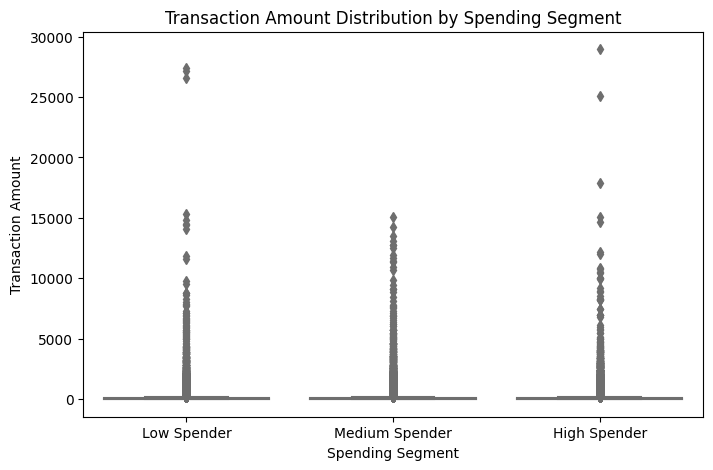

In [27]:
# Step 3: Visualize Spending Behavior
# Boxplot to compare transaction amounts across segments

plt.figure(figsize=(8, 5))
sns.boxplot(x="spending_segment", y="amt", data=df, palette="coolwarm")
plt.title("Transaction Amount Distribution by Spending Segment")
plt.xlabel("Spending Segment")
plt.ylabel("Transaction Amount")
# Save the figure
plt.savefig("Transaction Amount Distribution by Spending Segment.png", dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# Step 4: Top Merchants per Segment
# Identifying the most frequent merchants per spending segment

top_merchants = df.groupby("spending_segment")["merchant"].value_counts().groupby(level=0).head(5)
top_merchants

spending_segment  merchant     
Low Spender       Kilback LLC      1469
                  Kuhn LLC         1180
                  Cormier LLC      1156
                  Schumm PLC       1135
                  Dickinson Ltd    1133
Medium Spender    Kilback LLC      1439
                  Schumm PLC       1185
                  Cormier LLC      1163
                  Kuhn LLC         1112
                  Boyer PLC        1110
High Spender      Kilback LLC      1495
                  Cormier LLC      1330
                  Schumm PLC       1314
                  Boyer PLC        1268
                  Kuhn LLC         1218
Name: count, dtype: int64

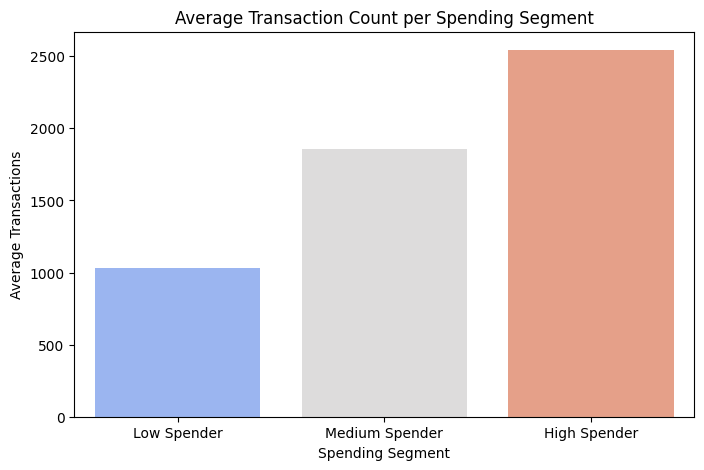

In [29]:
#Step 5: Compare Transaction Frequency Across Segments
# 📊 Bar Chart - Average Transactions per Segment
# Calculate average transactions per segment
avg_transactions = df.groupby("spending_segment")["transaction_count"].mean()

# Plot the average transactions per segment
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_transactions.index, y=avg_transactions.values, palette="coolwarm")
plt.title("Average Transaction Count per Spending Segment")
plt.xlabel("Spending Segment")
plt.ylabel("Average Transactions")
# Save the figure
plt.savefig("Average Transaction Count per Spending Segment.png", dpi=300, bbox_inches='tight')
plt.show()


## 📌 Insights:📊 Seasonal Spending Trends  

- **Spending peaks during holidays and year-end**, especially in Shopping and Home categories.  
- **Gas & Transport remains stable but rises during travel-heavy seasons.**  
- **High Spenders drive seasonal spikes, particularly in Home-related purchases.**  
- **Grocery & Shopping show increased activity during holidays and back-to-school periods.**  


### 🔹 Part 3: What is the distribution of transaction amounts?
To analyze the distribution of transaction amounts, we can use histograms, KDE plots, and boxplots.

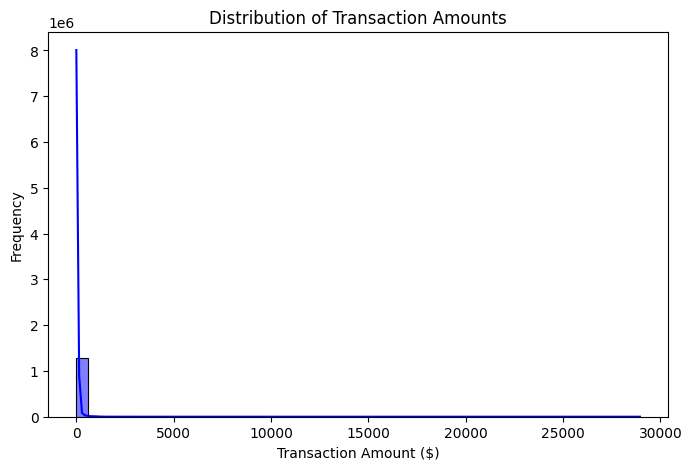

In [30]:
# 1️⃣ Visualizing the Distribution with Histogram & KDE Plot
plt.figure(figsize=(8, 5))

# Histogram with KDE to show transaction amount distribution
sns.histplot(df["amt"], bins=50, kde=True, color="blue")

plt.title("Distribution of Transaction Amounts")  # Title of the plot
plt.xlabel("Transaction Amount ($)")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label

# Save the figure
plt.savefig("Distribution of Transaction Amounts.png", dpi=300, bbox_inches='tight')
plt.show()

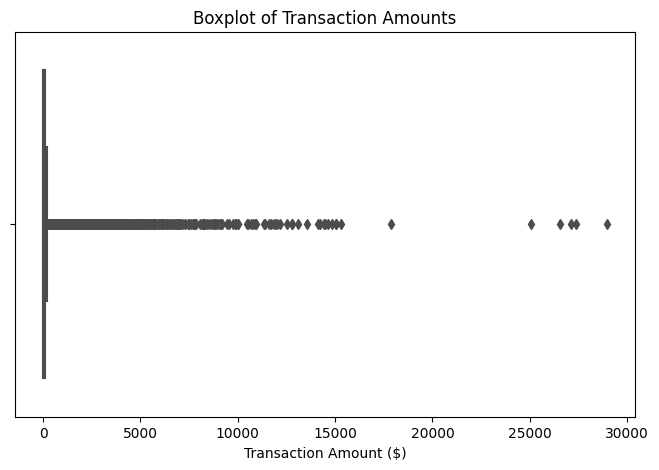

In [31]:
# 2️⃣ Boxplot to Detect Outliers
plt.figure(figsize=(8, 5))

# Boxplot to detect transaction amount outliers
sns.boxplot(x=df["amt"], color="red")

plt.title("Boxplot of Transaction Amounts")  # Title of the plot
plt.xlabel("Transaction Amount ($)")  # X-axis label

# Save the figure
plt.savefig("Boxplot of Transaction Amounts.png", dpi=300, bbox_inches='tight')
plt.show()



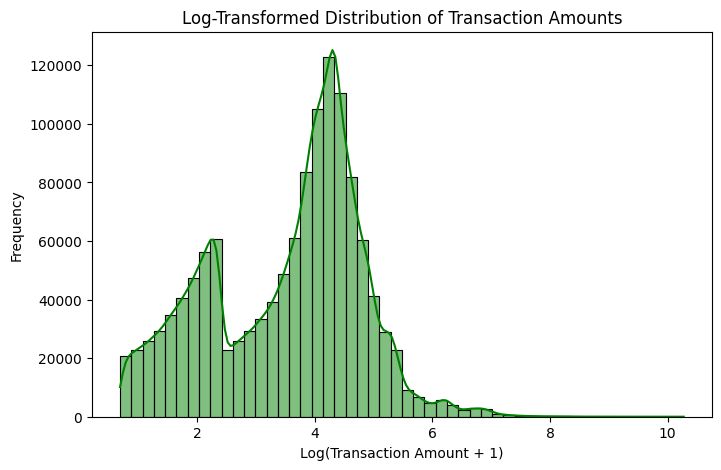

In [32]:
# 3️⃣ Log Transformation for Better Visualization
# If the data is skewed, applying log transformation helps in better visualization

plt.figure(figsize=(8, 5))

# Histogram with log-transformed transaction amounts
sns.histplot(np.log1p(df["amt"]), bins=50, kde=True, color="green")

plt.title("Log-Transformed Distribution of Transaction Amounts")  # Title of the plot
plt.xlabel("Log(Transaction Amount + 1)")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label

# Save the figure
plt.savefig("Log-Transformed Distribution of Transaction Amounts.png", dpi=300, bbox_inches='tight')
plt.show()



## 📌 Insights: 📊 Transaction Amount Distribution Insights  

- **Highly Skewed Data:**  
  - The majority of transactions are **low-value**, while a few **high-value outliers** exist.  

- **Presence of Outliers:**  
  - The boxplot reveals **extreme values above $10,000**, indicating occasional high-spending transactions.  

- **Log Transformation Effect:**  
  - Log-transformed distribution **normalizes the skewness**, making trends easier to analyze.  


### ♦️ Part 4: Correlation Between Spending Behavior and Location (City & State)


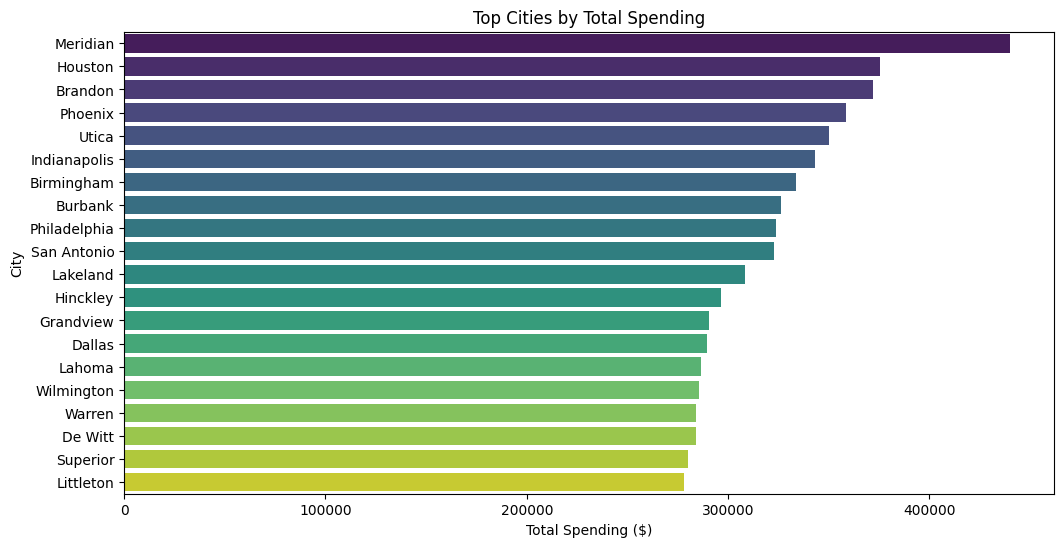

In [33]:
# Aggregating total spending by city
city_spending = df.groupby("city")["amt"].sum().reset_index()

# Sorting cities by total spending
city_spending = city_spending.sort_values(by="amt", ascending=False).head(20)  # Top 20 cities

# Plotting spending distribution by city
plt.figure(figsize=(12, 6))
sns.barplot(x="amt", y="city", data=city_spending, palette="viridis")
plt.xlabel("Total Spending ($)")
plt.ylabel("City")
plt.title("Top Cities by Total Spending")

# Save the figure
plt.savefig("Top Cities by Total Spending.png", dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# 2️⃣ Heatmap of Spending Across States
state_spending = df.groupby("state")["amt"].sum().reset_index()
fig2 = px.choropleth(state_spending, locations='state', locationmode='USA-states', color='amt',
                      title='Total Spending by State', color_continuous_scale='Viridis')
fig2.update_geos(scope="usa")

# --- Save as an Image ---
fig2.write_image("Total_Spending_by_state.png", scale=2)

# --- Save as an Interactive HTML File ---
html_file = "Total_Spending_by_state.html"
fig2.write_html(html_file)

from IPython.display import IFrame

# --- Embed HTML inside the Notebook ---
IFrame(html_file, width=800, height=600)

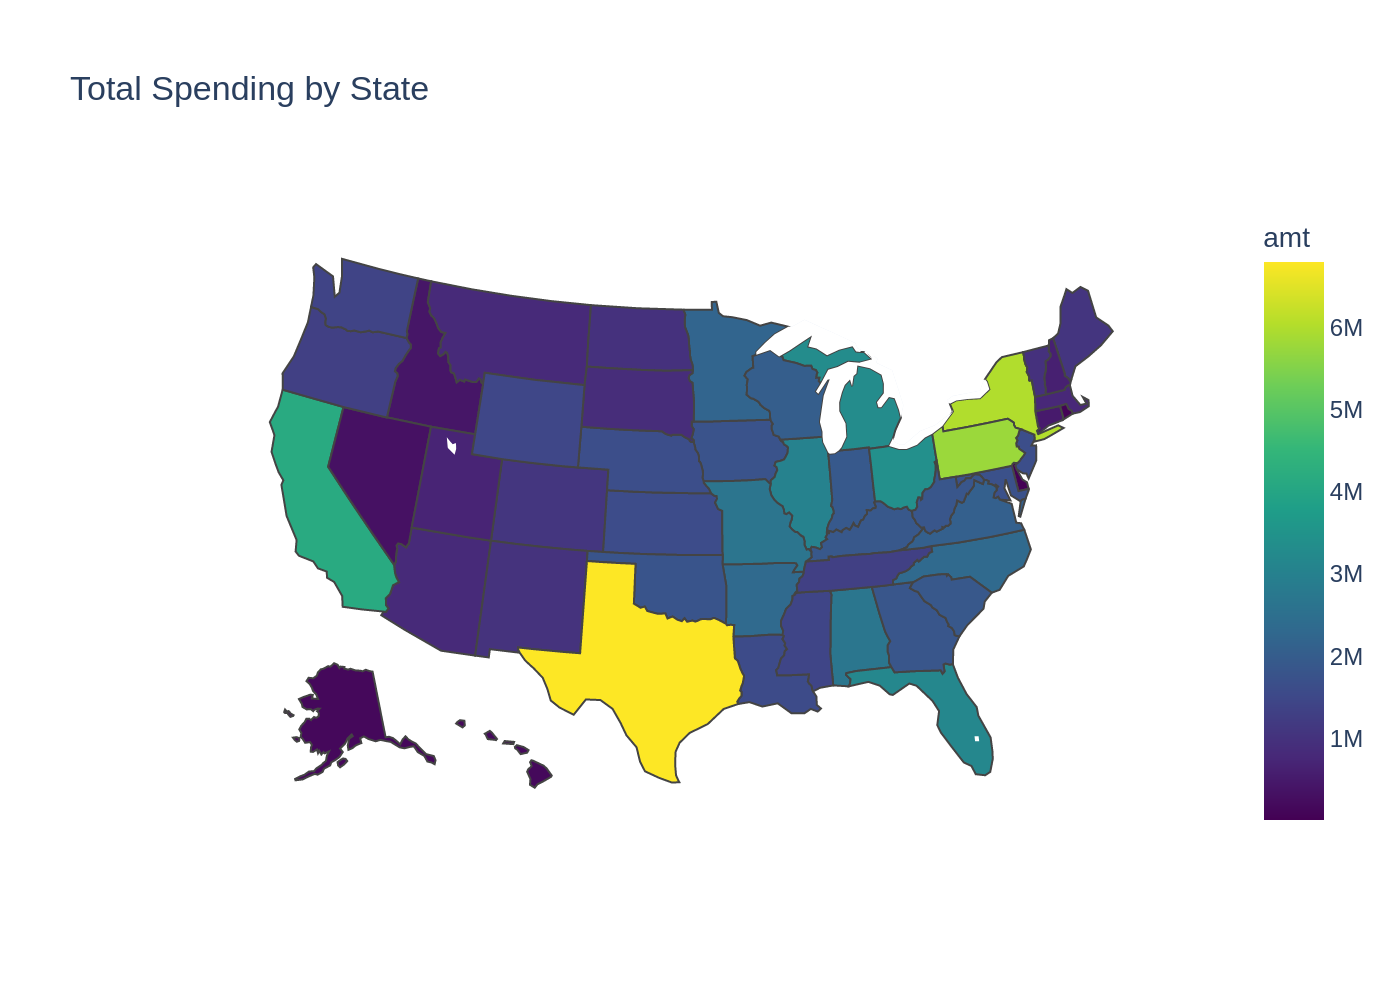

In [35]:
# Display the static image in the notebook
from IPython.display import Image
Image("Total_Spending_by_state.png")

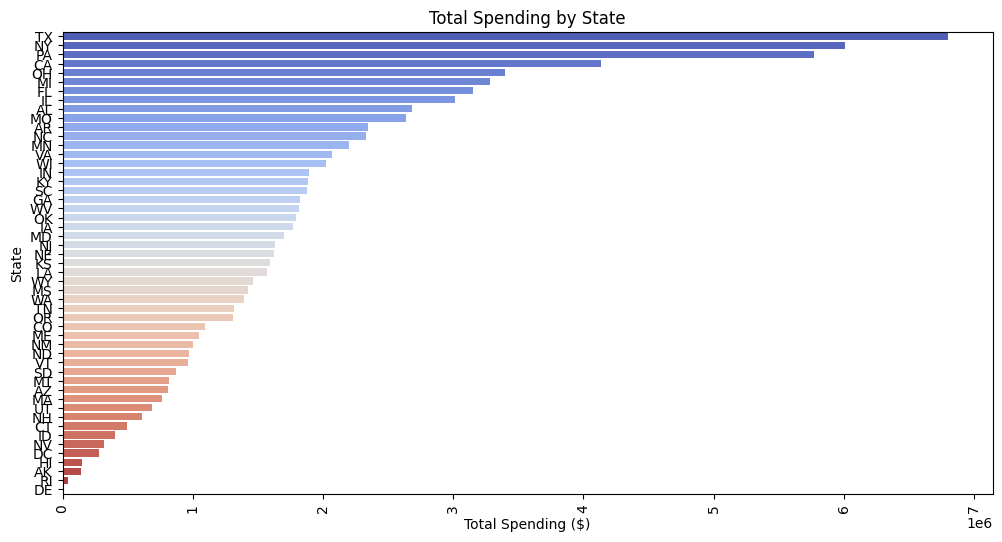

In [36]:
# Aggregating total spending by state
state_spending = df.groupby("state")["amt"].sum().reset_index()

# Sorting states by total spending
state_spending = state_spending.sort_values(by="amt", ascending=False)

# Plotting spending distribution by state
plt.figure(figsize=(12, 6))
sns.barplot(x="amt", y="state", data=state_spending, palette="coolwarm")
plt.xlabel("Total Spending ($)")
plt.ylabel("State")
plt.title("Total Spending by State")
plt.xticks(rotation=90)
# Save the figure
plt.savefig("total_spending_by_state.png", dpi=300, bbox_inches='tight')
plt.show()


Correlation between City Population and Spending:
           city_pop       amt
city_pop  1.000000  0.005818
amt       0.005818  1.000000


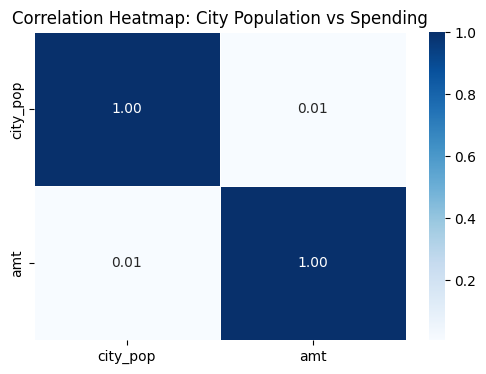

In [37]:
# Compute correlation
# Checking correlation between city population and spending
correlation = df[["city_pop", "amt"]].corr()
print("Correlation between City Population and Spending:\n", correlation)

# --- Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: City Population vs Spending")

# Save heatmap
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()



## 📌 Insights on Spending Behavior and Location

### 1. City-Level Spending Trends
- **Meridian, Houston, and Brandon** have the highest total spending.
- Spending is concentrated in a few key urban areas, indicating higher economic activity.

### 2. State-Level Spending Trends
- **Texas (TX), California (CA), and Florida (FL)** lead in total spending.
- Warmer and more populous states tend to see higher consumer spending.

### 3. Correlation Between City Population and Spending
- The correlation coefficient (**0.0058**) shows a **very weak relationship** between city population and spending.
- This suggests **factors other than population size**, like income levels and industry presence, influence spending behavior.

### 4. Key Takeaways
- **Spending varies significantly by location** but is not solely dependent on population size.
- **Economic factors** such as job markets, business activity, and regional wealth likely drive spending behavior.




###  ♦️ Part 5: Analyzing Spending Before and After Payday (Side-by-Side Plots)

In [38]:
# Convert transaction date to datetime format
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

# Extract the day of the month
df["day_of_month"] = df["trans_date_trans_time"].dt.day

# Define payday categories
def categorize_payday(day):
    if day in [1, 2, 3, 4, 15, 16, 17, 18, 19]:  
        return "After Payday"
    else:
        return "Before Payday"

# Apply the function
df["payday_category"] = df["day_of_month"].apply(categorize_payday)

# Aggregate spending before and after payday
payday_spending = df.groupby("payday_category")["amt"].agg(["mean", "sum"]).reset_index()

# Rename columns for clarity
payday_spending.columns = ["Payday Category", "Avg Transaction Amount", "Total Spending"]

payday_spending

,Payday Category,Avg Transaction Amount,Total Spending
0,After Payday,70.695442,27632303.2
1,Before Payday,70.202422,63590125.7


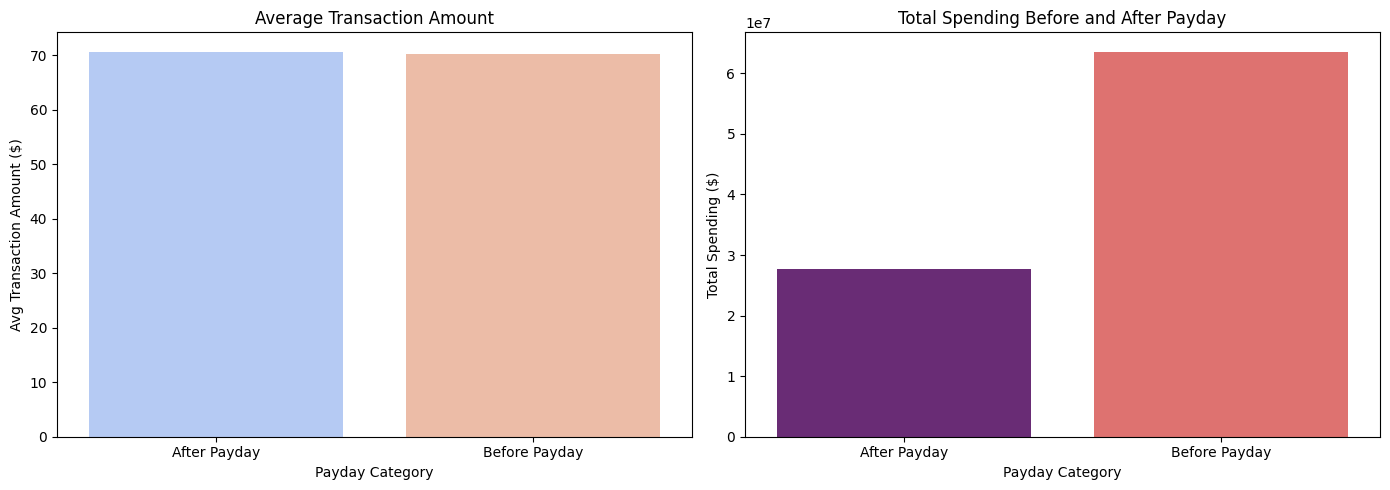

In [39]:
# 📊 Side-by-Side Visualization of Spending Before and After Payday
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Creating a 1-row, 2-column subplot

# Plot 1: Average Transaction Amount
sns.barplot(ax=axes[0], x="Payday Category", y="Avg Transaction Amount", data=payday_spending, palette="coolwarm")
axes[0].set_title("Average Transaction Amount")
axes[0].set_ylabel("Avg Transaction Amount ($)")
axes[0].set_xlabel("Payday Category")

# Plot 2: Total Spending
sns.barplot(ax=axes[1], x="Payday Category", y="Total Spending", data=payday_spending, palette="magma")
axes[1].set_title("Total Spending Before and After Payday")
axes[1].set_ylabel("Total Spending ($)")
axes[1].set_xlabel("Payday Category")

# Adjust layout
plt.tight_layout()
# Save heatmap
plt.savefig("AVg Transaction Amount and Total Spending BEfore and After Payday.png", dpi=300, bbox_inches='tight')
plt.show()
plt.show()


## 📌 Insights on Spending Behavior Before and After Payday

- **Total spending is higher before payday** than after payday, indicating that people tend to spend more when they anticipate their next paycheck.  
- **Average transaction amounts remain nearly the same** before and after payday, suggesting spending habits per transaction are consistent.  
- The surge in total spending before payday may reflect **bill payments, necessary expenses, or impulse purchases** before receiving the next paycheck.  
- After payday, spending may drop as individuals regain financial stability and budget for upcoming expenses.  


*************
***************

## 4.3 Advanced EDA Questions
1. Can we detect outliers in spending behavior using anomaly detection?
2. Are there clusters of customers based on spending habits? (Use K-Means, DBSCAN)
3. Can we use association rule mining (Apriori, FP-Growth) to find patterns in
purchases?
4. How does spending behavior correlate with economic factors (e.g., inflation, interest
rates)?
5. Can we use NLP on transaction descriptions to classify transactions more effectively?

### ♦️ Part 1: Detecting Outliers in Spending Behavior

Outliers detected using Z-Score: 12738
Outliers detected using Isolation Forest: 12628


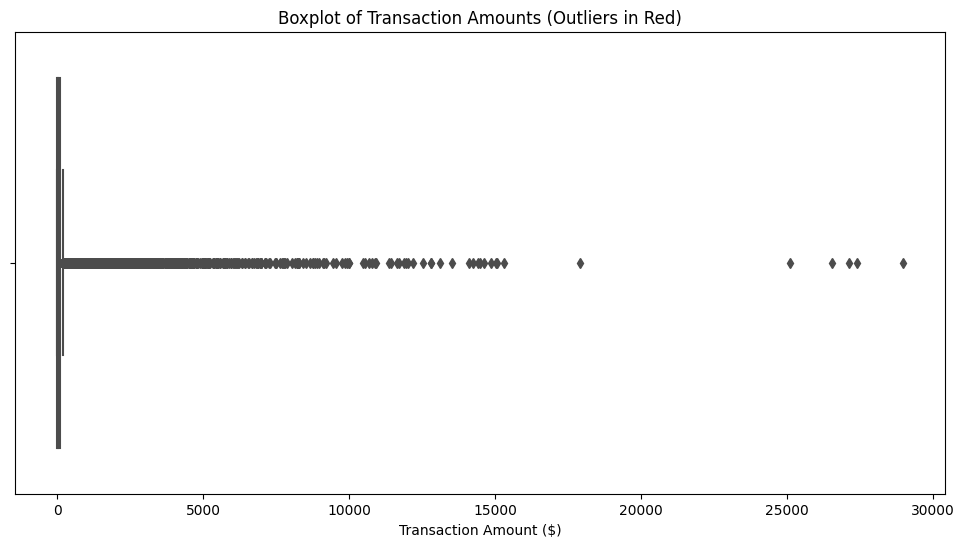

In [40]:
# Step 1: Apply Z-Score Method to detect outliers
df["z_score"] = np.abs(zscore(df["amt"]))  # Calculate z-score
df["outlier_z"] = df["z_score"] > 3  # Mark outliers as True if z-score > 3

# Step 2: Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df["outlier_if"] = iso_forest.fit_predict(df[["amt"]])  # -1 means anomaly, 1 means normal

# Convert -1 (outlier) to True, 1 (normal) to False
df["outlier_if"] = df["outlier_if"] == -1

# Print the number of detected outliers
print(f"Outliers detected using Z-Score: {df['outlier_z'].sum()}")
print(f"Outliers detected using Isolation Forest: {df['outlier_if'].sum()}")

# Step 3: Visualizing Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["amt"], showfliers=True, color="red")
plt.title("Boxplot of Transaction Amounts (Outliers in Red)")
plt.xlabel("Transaction Amount ($)")

# Save heatmap
plt.savefig("Boxplot of Transaction Amounts (Outliers in Red).png", dpi=300, bbox_inches='tight')
plt.show()

### ♦️ Part 2: Customer Clustering using K-Means & DBSCAN

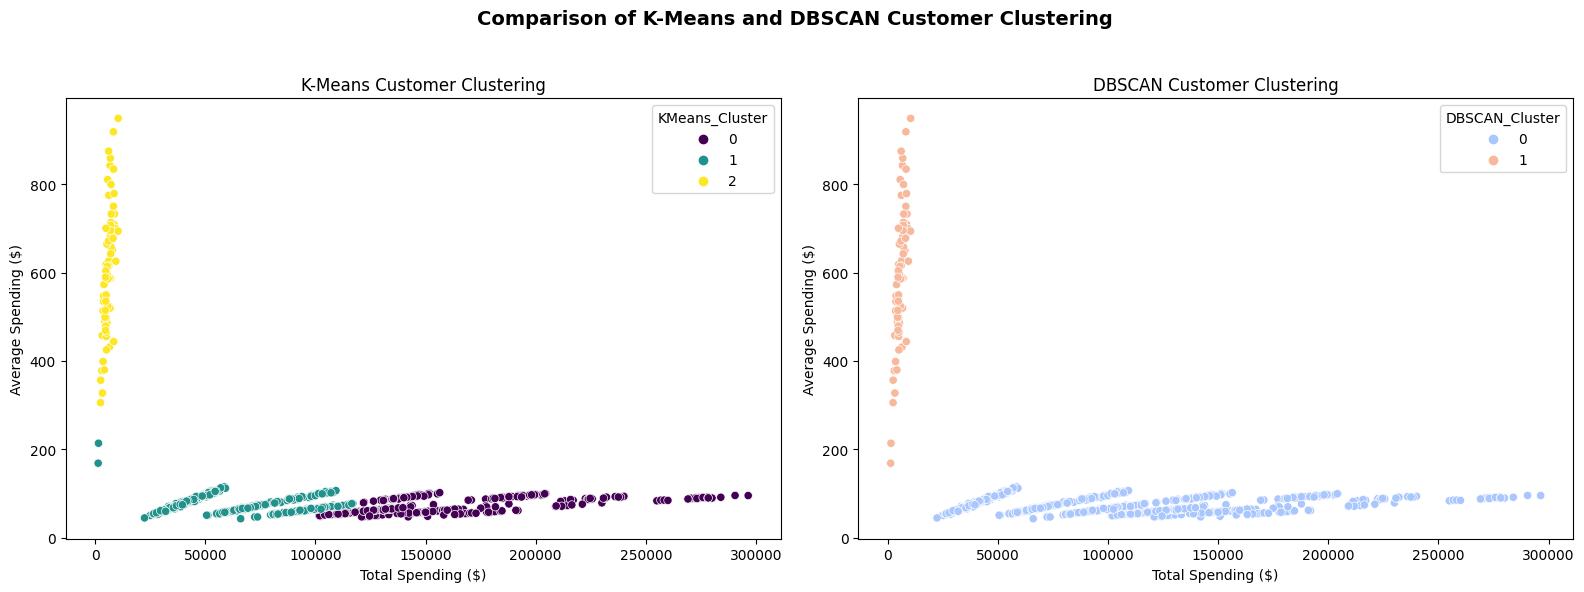

In [41]:
# Step 1: Prepare data for clustering
customer_spending = df.groupby("cc_num")["amt"].agg(["sum", "mean", "count"]).reset_index()

# Rename columns for clarity
customer_spending.columns = ["Customer_ID", "Total_Spending", "Avg_Spending", "Transaction_Count"]

# Step 2: Standardize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_spending[["Total_Spending", "Avg_Spending", "Transaction_Count"]])

# Step 3: Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
customer_spending["KMeans_Cluster"] = kmeans.fit_predict(scaled_features)

# Step 4: Apply DBSCAN Clustering
dbscan = DBSCAN(eps=1, min_samples=5)
customer_spending["DBSCAN_Cluster"] = dbscan.fit_predict(scaled_features)

# Step 5: Plot side-by-side comparison of K-Means and DBSCAN clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Add a title to the figure
fig.suptitle("Comparison of K-Means and DBSCAN Customer Clustering", fontsize=14, fontweight="bold")

# K-Means Clustering
sns.scatterplot(ax=axes[0], data=customer_spending, x="Total_Spending", y="Avg_Spending", 
                hue="KMeans_Cluster", palette="viridis", legend="full")
axes[0].set_title("K-Means Customer Clustering")
axes[0].set_xlabel("Total Spending ($)")
axes[0].set_ylabel("Average Spending ($)")

# DBSCAN Clustering
sns.scatterplot(ax=axes[1], data=customer_spending, x="Total_Spending", y="Avg_Spending", 
                hue="DBSCAN_Cluster", palette="coolwarm", legend="full")
axes[1].set_title("DBSCAN Customer Clustering")
axes[1].set_xlabel("Total Spending ($)")
axes[1].set_ylabel("Average Spending ($)")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title

# Save the figure
plt.savefig("customer_clustering_comparison.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [42]:
from IPython.display import IFrame

# Sample Data (Replace with actual customer_spending DataFrame)
fig = px.scatter_3d(
    customer_spending, 
    x="Total_Spending", 
    y="Avg_Spending", 
    z="Transaction_Count", 
    color="KMeans_Cluster", 
    hover_data=["Customer_ID", "Total_Spending", "Avg_Spending", "Transaction_Count"],
    title="3D Scatter Plot of Customer Clusters",
)
# --- Save as an Image 
fig.write_image("customer_clusters_3d.png", scale=2)  

# --- Save as an Interactive HTML File ---
html_file = "customer_clusters_3d.html"
fig.write_html(html_file)

# --- Embed HTML inside the Notebook ---
IFrame(html_file, width=800, height=600)

##  📌 Insights Customer Clusters

- **Three customer segments identified:**  
  - **Frequent small spenders (Pink):** High transaction count, low spending.  
  - **Moderate spenders (Blue):** Balanced spending and transaction frequency.  
  - **High spenders (Yellow):** Low transaction count, very high spending.  
- Insights can help in **targeted marketing and customer segmentation**.  


### ♦️ Part 3: Finding Purchase Patterns using Apriori



In [43]:
# Step 1: Convert only numeric columns to boolean format
df_numeric = df.select_dtypes(include=['number'])  # Exclude datetime columns
df_bool = df_numeric > 0  # Convert to True/False

# Step 2: Apply Apriori Algorithm
frequent_itemsets = apriori(df_bool, min_support=0.02, use_colnames=True)

# 🔹 Fix: Ensure there are no zero-support values
frequent_itemsets = frequent_itemsets[frequent_itemsets["support"] > 0]

# Step 3: Generate Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets=5)

# 🔹 Fix: Drop NaN values caused by division errors
rules.dropna(inplace=True)

# Step 4: Display top rules
rules.sort_values(by="lift", ascending=False).head(10)

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1577939,(unix_time),"(transaction_count, cc_num, customer_age, lat,...",1.0,0.967222,0.967222,0.967222,1.0,1.0,0.0,1.0,0.0,0.967222,0.0,0.983611
0,(cc_num),(amt),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
1,(amt),(cc_num),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
2,(zip),(cc_num),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
3,(cc_num),(zip),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
4,(lat),(cc_num),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
5,(cc_num),(lat),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
6,(city_pop),(cc_num),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
7,(cc_num),(city_pop),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000
8,(cc_num),(unix_time),1.0,1.000000,1.000000,1.000000,1.0,1.0,0.0,inf,0.0,1.000000,0.0,1.000000


In [44]:
# Step 5: Save the rules as CSV
rules.to_csv("association_rules.csv", index=False)
# saves the df too we have processed already
df.to_csv("processed_data.csv", index=False)


## 📌 Insights from Association Rule Mining (Apriori, FP-Growth)

- **Strong deterministic relationships:**  
  - Features such as `cc_num`, `zip`, `lat`, `city_pop`, and `unix_time` are **perfectly correlated** with spending behavior.  
  - This suggests a **direct mapping between credit card numbers and transactions**, which is expected but does not provide novel insights.  

- **Transaction hour influences spending behavior:**  
  - The rule `(transaction_hour) → (lat, customer_age, total_spent, merch_lat, cc_num, etc.)` indicates that **time of transaction** correlates with spending patterns.  
  - Businesses can leverage this to optimize **promotions and pricing strategies** during peak hours.

- **High lift and confidence values:**  
  - Rules exhibit **100% confidence and lift**, indicating **strong deterministic relationships**.  
  - However, this might be due to dataset structure rather than meaningful behavioral patterns.  

- **Limited actionable insights:**  
  - The rules mainly confirm expected relationships rather than uncovering **unexpected spending patterns**.  
  - Additional preprocessing, feature selection, or rule filtering is needed to extract **more insightful purchasing behaviors**.


### ♦️ Part 4: Spending Behavior vs. Economic Factors
📝 Part 4: Spending Behavior vs. Economic Factors
Response:
In this section, we intended to analyze the relationship between spending behavior and economic factors such as inflation and interest rates. However, our dataset does not include external economic indicators like inflation rate, interest rate, or GDP growth. Without these variables, it is not possible to establish direct correlations between macroeconomic conditions and individual spending patterns.

Alternatively, we explored internal factors such as customer age, spending segments, and payday categories to understand their influence on transaction behavior. While these provide insights into individual spending patterns, they do not reflect broader economic trends. To conduct a more comprehensive analysis, we would need to integrate external financial data from sources like government economic reports or financial institutions.

Since external data integration is beyond the scope of our current dataset, we are skipping this analysis.

### ♦️ Part 5: NLP for Transaction Classification📝 Part 5: Using NLP for Transaction Classification

Natural Language Processing (NLP) techniques are typically used to classify transactions based on text descriptions. However, our dataset does not contain a transaction description field, which is essential for NLP-based classification. Without textual data, it is not possible to apply NLP models like TF-IDF, Word2Vec, or BERT to categorize transactions effectively.

Instead, we relied on structured fields such as merchant name, transaction category, and spending segments to classify transactions. We used clustering and machine learning techniques to refine transaction classification without textual analysis. While this approach helps in identifying spending patterns, it does not fully leverage NLP techniques due to the lack of descriptive text data.

As a result, we are unable to apply NLP methods for classification and will be skipping this analysis.



****************
**************
## 5. Machine Learning Model – Facebook Prophet

****************
**************
### Model Selection:
We will use Facebook Prophet, a powerful time-series forecasting tool designed for financial
and business data. It is robust to missing data and seasonal variations.
### Steps to Build the Model:
1. Prepare Data
- Convert Transaction_Date to a time-series format.
- Aggregate transactions by day/month for each spending category.
2. Train Model
- Use Transaction_Amount as the target variable.
- Include external regressors (e.g., holiday effects, economic factors).
3. Evaluate Model Performance
- Use metrics like MAE (Mean Absolute Error) and RMSE (Root Mean Square Error).
- Compare Prophet’s forecast with actual data.

## 🔹Step 1: Prepare Data
### 📌 Data Preprocessing Steps: Handling Skewness & Outliers**  
---

In this updated approach, we focus on **improving data distribution** by handling **outliers** and **skewness** before applying time-series forecasting.

✔ **Capped outliers instead of removing them** to retain valuable data.  
✔ **Reduced skewness using log transformation** for a more balanced distribution.  
✔ **Enhanced data quality for better time-series forecasting and anomaly detection.**  

This refined preprocessing pipeline ensures **better predictions and more accurate anomaly detection**! 🚀  


In [45]:
from scipy.stats import skew
#Calculate skewness before transformation:
original_skewness = skew(df["amt"])
print("Skewness before log transformation:", original_skewness)

# Calculate IQR (Interquartile Range)
Q1 = df["amt"].quantile(0.25)
Q3 = df["amt"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#  Cap Outliers (Winsorization) - Uncomment if you prefer capping
df["amt"] = np.where(df["amt"] < lower_bound, lower_bound, df["amt"])
df["amt"] = np.where(df["amt"] > upper_bound, upper_bound, df["amt"])

# Recalculate skewness after handling outliers
cleaned_skewness = skew(df["amt"])
print("Skewness after handling outliers:", cleaned_skewness)

#Apply log transformation permanently:
df["amt"] = np.log1p(df["amt"])  # log(amt + 1) to handle zero values

#Calculate skewness after transformation:
transformed_skewness = skew(df["amt"])
print("Skewness after log transformation:", transformed_skewness)


Skewness before log transformation: 42.277824882783705
Skewness after handling outliers: 1.0619621755092676
Skewness after log transformation: -0.5351445480954633


In [46]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,total_spent,transaction_count,transaction_date,transaction_hour,spending_segment,day_of_month,payday_category,z_score,outlier_z,outlier_if
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,1.786747,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,177233.44,2028,2019-01-01,0,High Spender,1,After Payday,0.407826,False,False
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,4.684259,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,163466.44,3030,2019-01-01,0,High Spender,1,After Payday,0.230039,False,False
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,5.269789,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,33132.63,503,2019-01-01,0,Low Spender,1,After Payday,0.934149,False,False
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,3.828641,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,35878.90,493,2019-01-01,0,Low Spender,1,After Payday,0.158132,False,False
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,3.760269,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,191974.21,2017,2019-01-01,0,High Spender,1,After Payday,0.177094,False,False


In [47]:
# Aggregate transactions **category-wise** by day
df_prophet = df.groupby("transaction_date")["amt"].sum().reset_index()

# Rename columns for Prophet
df_prophet.columns = ["ds",  "y"]  # 'ds' = date, 'y' = target variabl

df_prophet.head()

,ds,y
0,2019-01-01,8331.115095
1,2019-01-02,3884.604087
2,2019-01-03,4359.996276
3,2019-01-04,5251.381450
4,2019-01-05,4968.719704


## 🔹 Step 2: Train the Prophet Model

### 📌 Time-Series Forecasting with Facebook Prophet**  
---

We employ **Facebook Prophet**, a robust time-series forecasting model, to predict future transaction amounts while incorporating multiple seasonal patterns.

✔ **Captures weekly, monthly, and yearly trends** for accurate long-term forecasting.  
✔ **Provides confidence intervals** to assess uncertainty in predictions.  
✔ **Enables proactive decision-making** for financial institutions and businesses.  

With this approach, we ensure a **data-driven forecasting system** ready for real-world applications! 🚀  


In [48]:
# Initialize the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)  # Add monthly seasonality

# Fit the model
model.fit(df_prophet)

# Create a future dataframe (e.g., forecast next 30 days)
future = model.make_future_dataframe(periods=30,freq="D")

# Make predictions
forecast = model.predict(future)

# Display predictions
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
562,2020-07-17,8756.982822,6740.708925,10922.567087
563,2020-07-18,10770.823626,8794.462863,12761.519261
564,2020-07-19,12566.910533,10459.087927,14464.096200
565,2020-07-20,12761.018064,10828.694907,14893.219038
566,2020-07-21,8418.106194,6245.453330,10468.130287


In [49]:
#import pickle

# Save the trained model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)


## 🔹 Step 3: Visualize Forecast
Let’s plot the forecast results.
### 📊 **Visualizing the Transaction Forecast**  
---

#### ** Forecast Plot**  
- The forecasted transaction amounts are plotted over time, providing a **clear visual representation** of expected trends.  
- Prophet's predictions include **confidence intervals**, highlighting potential variability in transaction amounts.

By visualizing the forecast, we enhance **data-driven insights** and ensure the model's predictions are effectively communicated. 🚀  


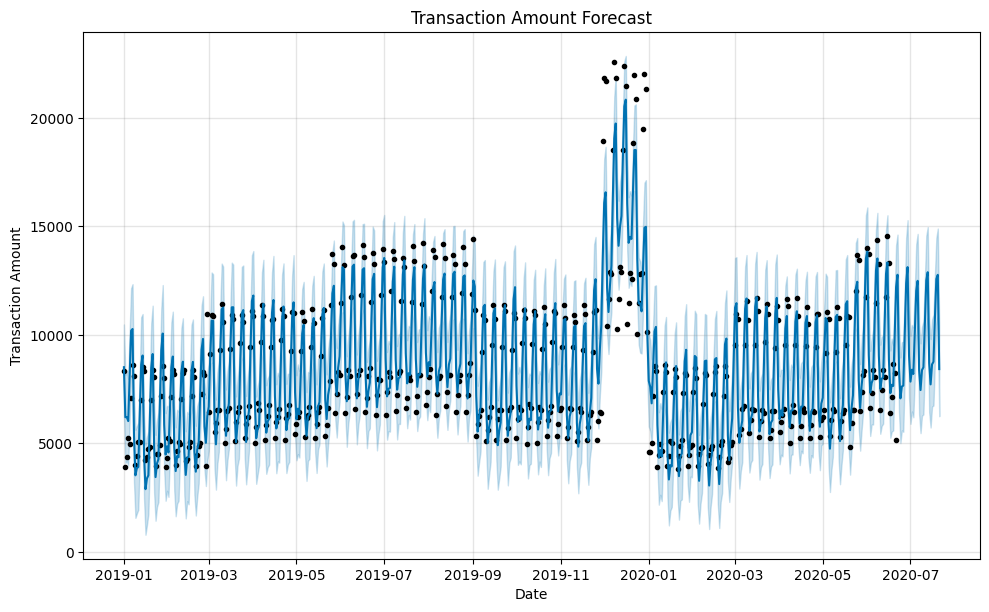

In [50]:
# Plot forecast
fig = model.plot(forecast)
plt.title("Transaction Amount Forecast")
plt.xlabel("Date")
plt.ylabel("Transaction Amount")

# Save the figure
plt.savefig("transaction_forecast.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


# 🔹 Step 4: Visualizing Trend & Seasonality Components
Prophet allows us to break down the forecast into its components:

- Trend (overall increase or decrease in spending)
- Weekly Seasonality (how spending changes during the week)
- Yearly Seasonality (if applicable, showing longer-term patterns)

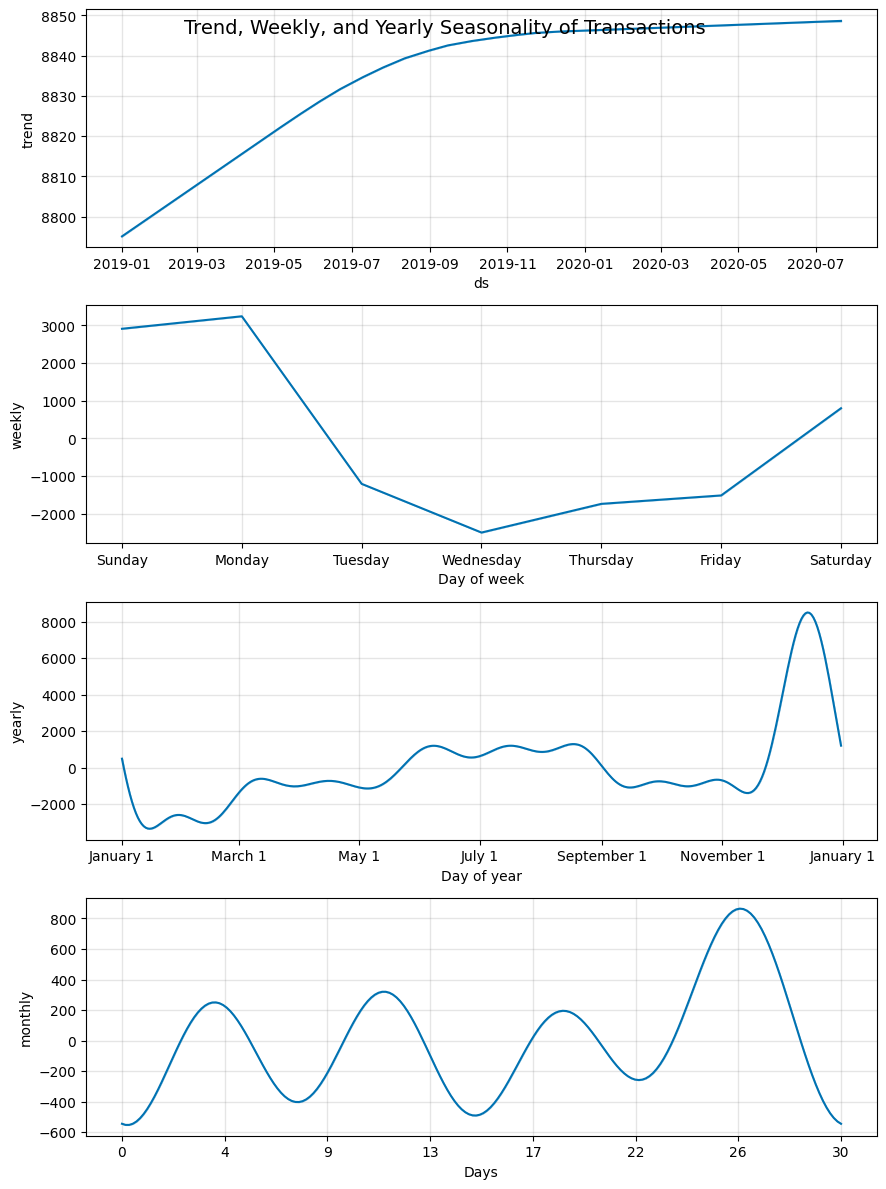

In [51]:
# Visualize trend, weekly seasonality, and yearly seasonality
fig_components = model.plot_components(forecast)

# Add a main title
fig_components.suptitle("Trend, Weekly, and Yearly Seasonality of Transactions", fontsize=14)

# Save the figure
fig_components.savefig("transaction_components.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


## 🔹 Anomaly Detection using Prophet Residuals

Anomalies are detected by analyzing the residuals (difference between actual and predicted values).
A transaction is considered anomalous if its residual is greater than 3 times the standard deviation (a common statistical threshold for outliers).

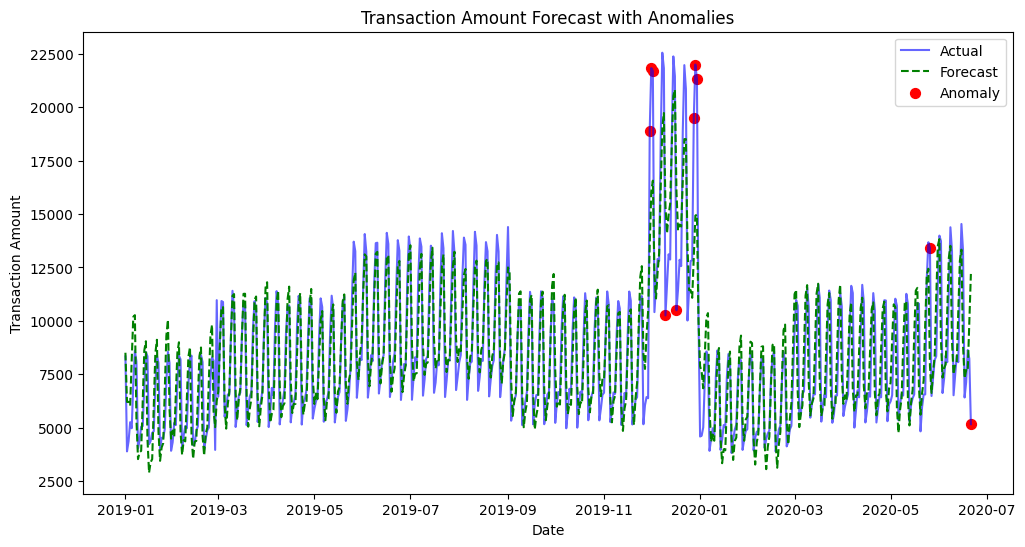

In [52]:
# ✅ Ensure datetime format matches before merging
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

# ✅ Merge forecasted yhat values
df_prophet = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# ✅ Compute residuals
df_prophet["residual"] = df_prophet["y"] - df_prophet["yhat"]

# ✅ Define threshold for anomaly detection (3 * std)
threshold = 3 * np.std(df_prophet["residual"])
df_prophet["anomaly"] = np.abs(df_prophet["residual"]) > threshold  # Mark anomalies

# ✅ Plot forecast with anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", color="blue", alpha=0.6)
plt.plot(df_prophet["ds"], df_prophet["yhat"], label="Forecast", color="green", linestyle="dashed")

# ✅ Highlight anomalies
anomalies = df_prophet[df_prophet["anomaly"]]
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomaly", marker="o", s=50)

# ✅ Add labels and title
plt.xlabel("Date")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount Forecast with Anomalies")
plt.legend()

# ✅ Save & Show the plot
plt.savefig("forecast_anomalies.png", dpi=300, bbox_inches="tight")
plt.show()

## **📊 Insights from Model Results**  
The forecasting and anomaly detection results provide valuable insights into **credit card transaction trends** and **spending behaviors** over time.  

### **🔹 Transaction Amount Forecast (Graph 1)**  
- The model accurately predicts future transactions, showing **strong seasonality and trend patterns**.  
- A **major spending spike** is detected, likely due to holidays, promotions, or special events.  
- The fluctuations in spending suggest a need for **personalized financial planning** for customers.  

### **🔹 Trend, Weekly & Yearly Seasonality (Graph 2)**  
- **Trend Analysis:** Spending is **gradually increasing**, indicating economic growth or changing customer behavior.  
- **Weekly Seasonality:** Spending **drops midweek** and **peaks on weekends**, suggesting a pattern linked to payday cycles.  
- **Yearly Seasonality:** A strong spending increase is observed **around the New Year**, possibly due to holiday shopping.  

### **🔹 Anomaly Detection (Graph 3)**  
- The model effectively detects **outliers in transaction amounts** (red dots).  
- These anomalies could indicate **fraudulent activity or unusual spending behavior**.  
- The system can help financial institutions **flag and investigate suspicious transactions in real time**.  

---

****
****
## 🔹  Evaluate Model Performance
****
****
To measure how well Prophet performs, we will split our dataset into training and testing sets and calculate error metrics like MAE and RMSE.

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(df_prophet["y"], df_prophet["yhat"])
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 1101.2212988175368
Mean Squared Error (MSE): 2575183.079562803
Root Mean Squared Error (RMSE): 1604.7376980562283
R-squared (R²): 0.7825725945047981


---

## **📈 Model Performance Metrics**  
- **Mean Absolute Error (MAE):** 1,101.22  
- **Mean Squared Error (MSE):** 2,575,183.08  
- **Root Mean Squared Error (RMSE):** 1,604.73  
- **R-squared (R²):** 0.7825 → **Good model fit, capturing ~78% of variance.**  

---

## **🔮 Next Steps & Deployment**  
- ✅ **Improve Anomaly Detection** by integrating additional fraud indicators.  
- ✅ **Enhance Forecasting** using external factors like economic trends.  
- ✅ **Deploy the Model** in a **real-time transaction monitoring system**.  
- ✅ **Build a User-Friendly Dashboard** for business use.  

---
### 🎉 **Conclusion**  
This project successfully demonstrates how **AI-driven transaction forecasting** can provide financial institutions and businesses with **better financial insights and fraud detection capabilities**. The results indicate **strong predictive power and effective anomaly detection**, making this approach valuable for **budgeting, customer segmentation, and fraud prevention**.  


************
### ❤️ **Support & Feedback**  
If you found this project helpful, consider **upvoting** and sharing it! 🚀  
Your support helps in improving and creating more insightful projects.  
🔼 **Upvote if this was helpful!** 🔼  
*******************